In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import linregress
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from skimage.color import rgb2gray
from skimage.draw import disk
from matplotlib.patches import Circle
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Functions

In [ ]:
def scatter_plot(df, x_col, y_col, 
                 x_lim=None, 
                 y_lim=None):

    plt.figure(figsize=(4, 4), dpi=150)
    plt.scatter(df[x_col], df[y_col], alpha=0.6)

    plt.xlabel(x_col.replace("_", " "))
    plt.ylabel(y_col.replace("_", " "))

    # Fixed scale
    if x_lim is not None:
        plt.xlim(x_lim)

    if y_lim is not None:
        plt.ylim(y_lim)

    plt.tight_layout()
    plt.show()



def plot_histogram(df, column, bins=50, xlabel=None, title=None,
                   figsize=(4, 3), dpi=200):
    """
    Plot histogram for a dataframe column.

    Parameters:
    df : pandas.DataFrame
    column : str
        Column name to plot
    bins : int
        Number of bins
    xlabel : str (optional)
    title : str (optional)
    """

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.hist(
        df[column].dropna(),
        bins=bins,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8
    )

    ax.set_xlabel(xlabel if xlabel else column, fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.set_title(title if title else f"Distribution of {column}", fontsize=12)

    # Clean style
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


# Data import

In [100]:
path_data = "./examples/test_10.csv"
path_image = "./examples/test_10.tif"

845


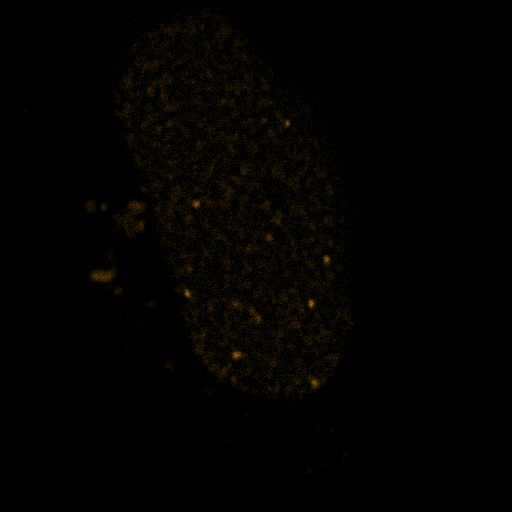

In [101]:
df = pd.read_csv(path_data, encoding="latin1")
print(df.shape[0])

# open image
image = Image.open(path_image).convert("RGB")
image

In [102]:
df.head()

,ï»¿id,x [nm],y [nm],sigma [nm],intensity [photon],uncertainty_xy [nm]
0,1,2045.116619,8873.425184,91.965561,180.300947,12.544727
1,2,7185.558015,16354.815760,240.039654,3773.919861,8.446720
2,3,7214.541563,16656.961800,267.812220,3943.786308,11.306968
3,4,7699.881351,22091.793570,286.647717,12177.241440,10.625823
4,5,8205.795841,22121.623630,397.755991,22377.221210,10.842392


## Draw circle area

In [103]:
# convert RGB → grayscale
gray = rgb2gray(image)

orig_size=(2560, 2560)
pixel_size_original_nm=16.0

jpg_w, jpg_h = image.size
orig_w, orig_h = orig_size

# scaling from original px -> current image px
sx = jpg_w / orig_w
sy = jpg_h / orig_h

H, W = image.size

x_list = []
y_list = []
sigma_list = []
mean_list = []

for _, row in df.iterrows():
    x_nm = row["x [nm]"]
    y_nm = row["y [nm]"]
    sigma_nm = row["sigma [nm]"]

    # nm -> original pixels
    x_orig_px = x_nm / pixel_size_original_nm
    y_orig_px = y_nm / pixel_size_original_nm
    sigma_orig_px = sigma_nm / pixel_size_original_nm

    # original pixels -> current image pixels
    x_px = int(round(x_orig_px * sx))
    y_px = int(round(y_orig_px * sy))
    sigma_px= int(round(sigma_orig_px * sx))

    # --- build circular mask (clipped to image) ---
    rr, cc = disk((y_px, x_px), sigma_px, shape=(H, W))  # (row=y, col=x)
    mask = np.zeros((H, W), dtype=bool)
    mask[rr, cc] = True

    # --- mean intensity in ROI ---
    mean_intensity = gray[mask].mean()

    # store values
    x_list.append(x_px)
    y_list.append(y_px)
    sigma_list.append(sigma_px)
    mean_list.append(mean_intensity)

# add new columns
df["x_px"] = x_list
df["y_px"] = y_list
df["sigma_px"] = sigma_list
df["mean_intensity"] = mean_list


/home/lopatushka/miniconda3/envs/imagej/lib/python3.11/site-packages/skimage/draw/draw.py:51: RuntimeWarning: invalid value encountered in divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 + (
/home/lopatushka/miniconda3/envs/imagej/lib/python3.11/site-packages/skimage/draw/draw.py:52: RuntimeWarning: invalid value encountered in divide
  (r * sin_alpha - c * cos_alpha) / c_rad
/tmp/ipykernel_1209/72644681.py:42: RuntimeWarning: Mean of empty slice
  mean_intensity = gray[mask].mean()
/home/lopatushka/miniconda3/envs/imagej/lib/python3.11/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(gray, cmap="gray")

for x_px, y_px, r_px in zip(df["x_px"], df["y_px"], df["sigma_px"]):
    # circle outline
    ax.add_patch(Circle((x_px, y_px), r_px, fill=False, edgecolor="red", linewidth=1))
    # center dot
    ax.scatter(x_px, y_px, c="red", s=6)

ax.axis("off")
plt.show()

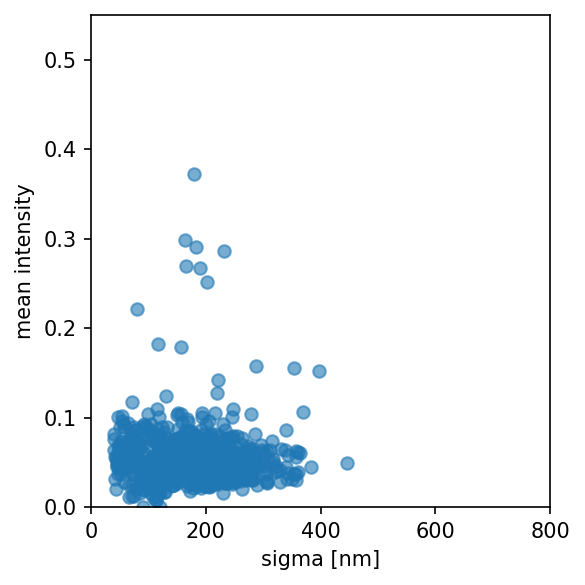

In [104]:
scatter_plot(df, "sigma [nm]", "mean_intensity",   x_lim=(0, 800), y_lim=(0, 0.55))

In [ ]:
# df_filtered = df[df["sigma [nm]"] > 600]
# df_filtered.shape[0]

In [108]:
df.head()

,ï»¿id,x [nm],y [nm],sigma [nm],intensity [photon],uncertainty_xy [nm],x_px,y_px,sigma_px,mean_intensity,cluster
0,1,2045.116619,8873.425184,91.965561,180.300947,12.544727,26,111,1,0.019042,0.0
1,2,7185.558015,16354.815760,240.039654,3773.919861,8.446720,90,204,3,0.067240,0.0
2,3,7214.541563,16656.961800,267.812220,3943.786308,11.306968,90,208,3,0.061456,0.0
3,4,7699.881351,22091.793570,286.647717,12177.241440,10.625823,96,276,4,0.158188,-1.0
4,5,8205.795841,22121.623630,397.755991,22377.221210,10.842392,103,277,5,0.151908,-1.0


In [107]:
X = df[["sigma [nm]", "mean_intensity"]].dropna()
X_scaled = StandardScaler().fit_transform(X)

db = DBSCAN(eps=0.5, min_samples=10)
labels = db.fit_predict(X_scaled)

df.loc[X.index, "cluster"] = labels

# Kmean

In [ ]:
n_clusters = 3

# Select TWO columns
X = df[["mean_intensity", "sigma [nm]"]].dropna()

# Run KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Add cluster labels back to dataframe
df.loc[X.index, "cluster"] = labels

centers = kmeans.cluster_centers_

print("Cluster centers:")
for i, c in enumerate(centers):
    print(f"Cluster {i}: mean_intensity={c[0]:.2f}, sigma={c[1]:.2f}")

In [ ]:
df.head()

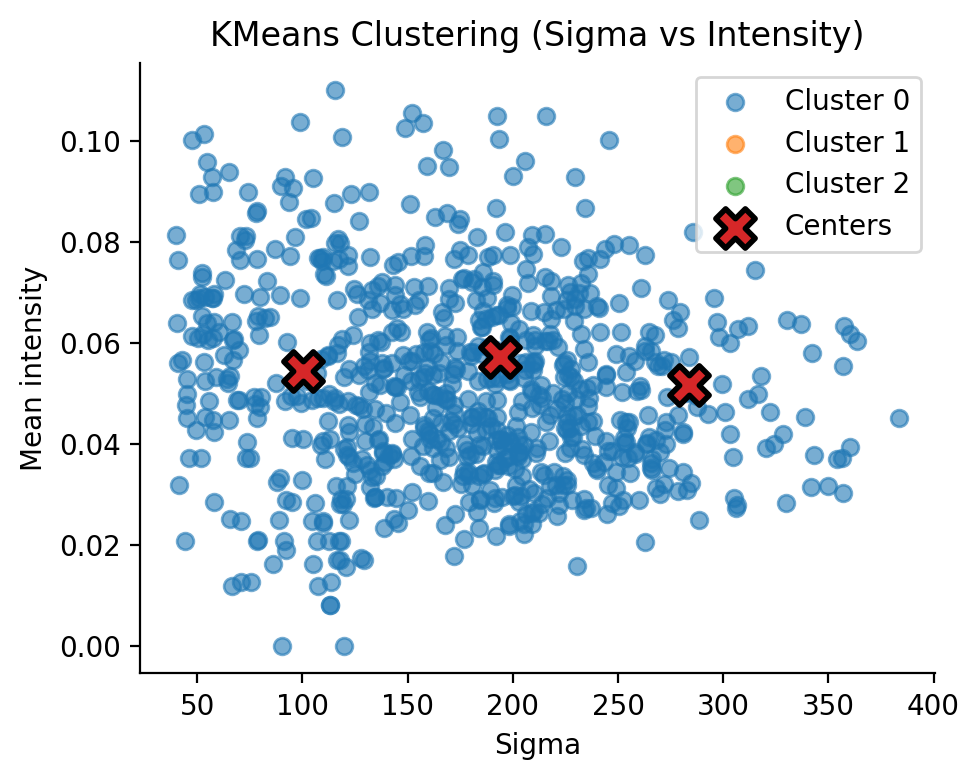

In [109]:
plt.figure(figsize=(5, 4), dpi=200)

# Scatter plot of clusters
for cluster_id in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster_id]
    plt.scatter(cluster_data["sigma [nm]"],
                cluster_data["mean_intensity"],
                alpha=0.6,
                label=f"Cluster {cluster_id}")

# Plot cluster centers
plt.scatter(centers[:, 1],   # sigma
            centers[:, 0],   # mean_intensity
            marker="X",
            s=200,
            linewidths=2,
            edgecolors="black",
            label="Centers")

plt.xlabel("Sigma")
plt.ylabel("Mean intensity")
plt.title("KMeans Clustering (Sigma vs Intensity)")
plt.legend()

# Clean look
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
plot_histogram(df, column="sigma [nm]", xlabel="Sigma (nm)", title="Distribution of Sigma")

Task:
1. sigma - 2 populations (KMeans)
2. Outliers of sigma - check them:
 - big bright dots: analyze as a third population
 - aggregates: analyze separatly
 - MFI of nucleus - big dots/aggregates
3. How the bg susbstruction affects the sigma, MFI of foci?

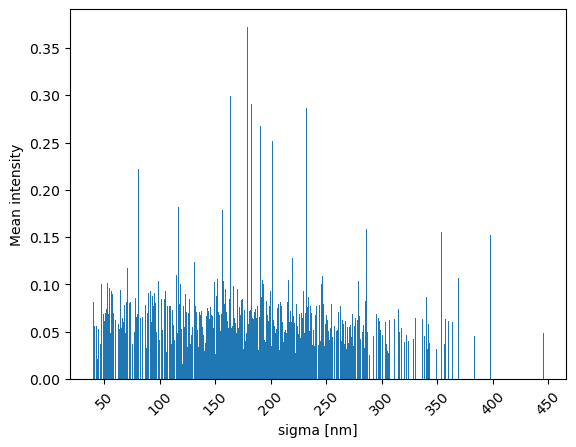

In [110]:
means = df.groupby("sigma [nm]")["mean_intensity"].mean()
plt.bar(means.index, means.values)
plt.xlabel("sigma [nm]")
plt.ylabel("Mean intensity")
plt.xticks(rotation=45)
plt.show()

# Filtration

In [ ]:
df_bright = df[df["sigma [nm]"] > 400]
df_medium = df[(df["sigma [nm]"] > 150) & (df["sigma [nm]"] <= 400)]
df_dark = df[df["sigma [nm]"] <= 150]

print("Bright foci count:", df_bright.shape[0])
print("Medium foci count:", df_medium.shape[0])
print("Dark foci count:", df_dark.shape[0])

In [ ]:
df1 = df[df["sigma [nm]"] > 500]
print("Bright foci count:", df1.shape[0])